In [1]:
#!pip install planetary_computer

  Obtaining dependency information for planetary_computer from https://files.pythonhosted.org/packages/4f/7a/3965a2b58d172e106c1064af19707d29f86a0142c28ff40185490a0a8cfe/planetary_computer-1.0.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 950.0 kB/s eta 0:00:00 0:00:01
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.19.0
    Uninstalling jsonschema-4.19.0:
      Successfully uninstalled jsonschema-4.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-events 0.7.0 requires jsonschema[format-nongpl]>=4.18.0, but you have jsonschema 4.17.3 which is incompatible.
jupyterlab-server 2.25.0 requires jsonschema>=4.18.0, but you have jsonschema 4.17.3 which is incompatible.


In [5]:
# based on exmaples from
# https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/
# https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import glob
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import re
import datetime
import pandas as pd
from shapely.geometry import box
import odc.stac
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio
import geopandas as gpd

<Axes: >

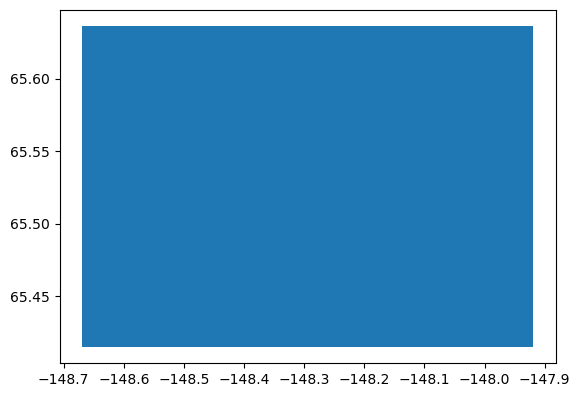

In [8]:
bounds_latlon = gpd.read_file('livengood.geojson')
bounds_latlon.plot()

In [12]:

catalog = pystac_client.Client.open(
"https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["cop-dem-glo-30"],
    bbox=bounds_latlon.total_bounds)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 2 Items


In [14]:
import stackstac

In [15]:
dm_raster = stackstac.stack(items).squeeze()

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [24]:
dm_raster = dm_raster.max(dim='time')

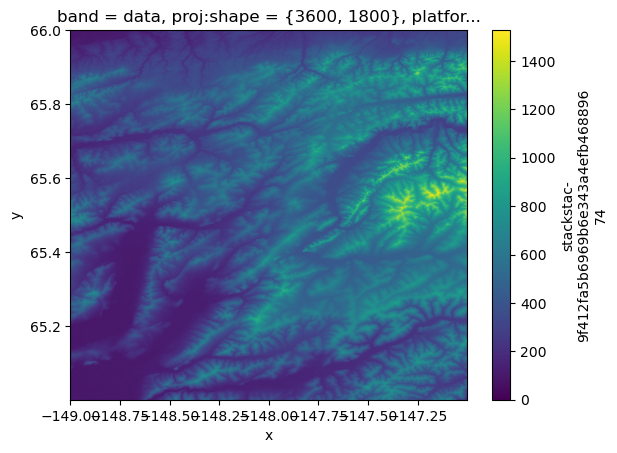

In [25]:
dm_raster.plot()

In [2]:
def cop30_for_aso(aso_raster_fn):
    aso_raster = rxr.open_rasterio(aso_raster_fn).squeeze()
    aso_raster = aso_raster.where(aso_raster>=0, drop=True)
    aso_raster = aso_raster.interpolate_na(dim='x')
    bounds_latlon = box(*aso_raster.rio.transform_bounds("EPSG:4326"))
    
    catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["cop-dem-glo-30"],
        intersects=bounds_latlon)

    # Check how many items were returned
    items = search.item_collection()
    print(f"Returned {len(items)} Items")
    
    data = []
    for item in items:
        dem_path = planetary_computer.sign(item.assets['data']).href
        data.append(rxr.open_rasterio(dem_path))
    cop30_da = merge_arrays(data)  
    
    # clip to ASO extent
    cop30_da = cop30_da.squeeze().rio.reproject_match(aso_raster, resampling=rio.enums.Resampling.bilinear)
    
    cop30_da.to_netcdf(f'../data/cop30/cop30_for_{aso_raster_fn.split("/")[-1][:-4]}.nc')
    
    #return cop30_da, aso_raster

In [3]:
#fn = '/home/jovyan/crunchy-snow/data/ASO/ASO_50m_SD_cleaned/utm11n/ASO_50M_SD_Carson_20220311_clean.tif'

In [4]:
#cop30_da, aso = cop30_for_aso(fn)

In [5]:
# f, ax = plt.subplots(1, 2, figsize = (10, 10))
# ax[0].imshow(cop30_da)
# ax[0].set_aspect('equal')
# ax[1].imshow(aso, vmin=0, vmax=2, cmap = "Blues")
# ax[1].set_aspect('equal')
# plt.tight_layout()

In [6]:
def cop30_for_aso_all(dir_path):
    error_paths = []
    raster_paths = glob.glob(f'{dir_path}/*/ASO_50M_SD*.tif')
    for i, path in enumerate(raster_paths):
        print(f'----\nworking on {path.split("/")[-1]}, {i+1}/{len(raster_paths)}\n----')
        
        try:
            cop30_for_aso(path)
        except:
            print('encountered error downloading, skipping for now')
            error_paths.append(path)

In [7]:
dir_path = '/home/jovyan/crunchy-snow/data/ASO/ASO_50m_SD_cleaned'
cop30_for_aso_all(dir_path)

----
working on ASO_50M_SD_BlueRiver_20230529_clean.tif, 1/252
----
Returned 2 Items
----
working on ASO_50M_SD_Animas_20210419_clean.tif, 2/252
----
Returned 2 Items
----
working on ASO_50M_SD_EastRiver_20230523_clean.tif, 3/252
----
Returned 4 Items
----
working on ASO_50M_SD_EastRiver_20220518_clean.tif, 4/252
----
Returned 4 Items
----
working on ASO_50M_SD_SouthPlatte_20230416_clean.tif, 5/252
----
Returned 4 Items
----
working on ASO_50M_SD_USCOCM_20190407_clean.tif, 6/252
----
Returned 4 Items
----
working on ASO_50M_SD_TaylorAndLottis_20230523_clean.tif, 7/252
----
Returned 2 Items
----
working on ASO_50M_SD_USCOGE_20180331_clean.tif, 8/252
----
Returned 4 Items
----
working on ASO_50M_SD_BlueRiver_20190624_clean.tif, 9/252
----
Returned 2 Items
----
working on ASO_50M_SD_BlueRiver_20230416_clean.tif, 10/252
----
Returned 2 Items
----
working on ASO_50M_SD_WindyGap_20230416_clean.tif, 11/252
----
Returned 4 Items
----
working on ASO_50M_SD_RoaringFork_20230528_clean.tif, 12/252